---
title: Grading distinctiveness
bibliography: references.bib
jupyter:
  kernelspec:
    display_name: Python (Pyseter)
    language: python
    name: pyseter_env
---

Pyseter comes with an experimental algorithm for grading individual distinctiveness. This can be useful for partially marked populations, e.g., spinner dolphins. 

## Background

To understand the distinctiveness algorithm, it can be helpful to first introduce one of Pyseter’s clustering algorithms, `NetworkCluster`. Network clustering works with similarity scores, which represent the similarity between two individuals in a pair of images. We can define a threshold score, the `match_threshold`, above which we consider two individuals to be the same. That is, if the similarity score between two images is above a certain threshold, we cluster them into a proposed ID. As such, network clustering works by treating the query set as a network, where the nodes are images and the edges are similarity scores above a threshold. Each set of connected components, i.e., images whose similarity scores are above the match threshold, represents a proposed ID.

We might expect the indistinct individuals to cluster together. In the context of facial recognition, @deng-2023-ui observed that “unrecognizable identities”, e.g., extremely blurry or masked faces, tend to cluster together. As such, for partially marked populations, the largest cluster in the query set may represent every indistinct individual. Following @deng-2023-ui, we can compute the average feature vector for this cluster. The distance between this average feature vector and the feature vector for each image is the distinctiveness score for that image. As such, the score applies to the image, not the animal. To get a score for an animal, users could average the distinctiveness scores across images for that animal.

## Spinner dolphin example

The images in this example were collected during a multi-year photo-ID survey of spinner dolphins in Hawaiʻi. We'll load in the saved feature vectors from before. 

In [ ]:
%config InlineBackend.figure_format = 'retina'

from PIL import Image
from pyseter.grade import rate_distinctiveness
from pyseter.sort import load_features
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import pandas as pd

# load the features
feature_dir = 'working_dir/features'
out_path = feature_dir + '/features.npy'
filenames, feature_array = load_features(out_path)

We need to supply two arguments to `rate_distinctiveness`: the `feature_array`, and the `match_threshold`. The lower the match threshold, the more individuals will end up in the unrecognizable identity cluster, potentially including distinct individuals. Conversely, a high match threshold might split the indistinct individuals into many clusters. 

In [2]:
distinctiveness = rate_distinctiveness(feature_array, match_threshold=0.5)

Unrecognizable identity cluster consists of 196 images.


/Users/PattonP/miniforge3/envs/pyseter_env/lib/python3.14/site-packages/pyseter/grade.py:35: UserWarning: Distinctiveness grades are experimental and should be verified.
  warn(UserWarning('Distinctiveness grades are experimental and should be verified.'))


`rate_distinctiveness` warns you that this is experimental, and lets you know how many individuals ended up in the unrecognizable identity. This should be a quick sanity check. 

We can plot the results of the score with the receiver operator characteristic (ROC) curve. This treats the distinctiveness grade as a classifier probability. The area under the curve tells us how good the classifier is, i.e., in terms of the number of false positives and false negatives. 

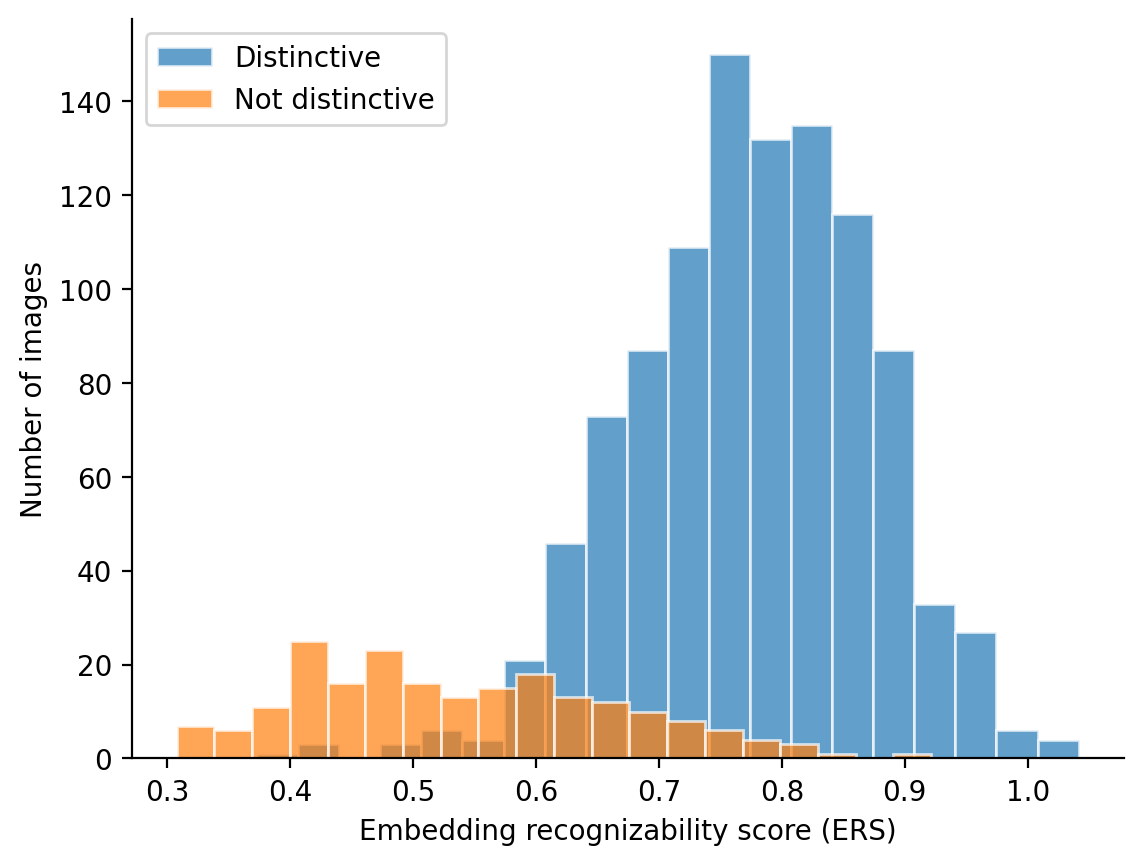

In [19]:
# download the true distinctiveness scores
data_url = (
    'https://raw.githubusercontent.com/philpatton/pyseter/main/' 
    'data/spinner-distinct.csv'
)
spinner_distinct = pd.read_csv(data_url)

# merge with the predicted distinctiveness scores
ers_df = pd.DataFrame({'image': filenames, 'ers': distinctiveness})
ers_df = ers_df.merge(spinner_distinct)

# compute the curve first, which will get displayed
y_score = ers_df['ers']
y_test, _ = ers_df.distinctiveness.factorize()

fig, ax = plt.subplots()

ax.hist(y_score[y_test == 0], bins=20, ec='w', alpha=0.7, label='Distinctive')
ax.hist(y_score[y_test == 1], bins=20, ec='w', alpha=0.7, label='Not distinctive')

ax.legend()

ax.spines[['right', 'top']].set_visible(False)

ax.set_xlabel('Embedding recognizability score (ERS)')
ax.set_ylabel('Number of images')

plt.show()


We can see that distinctive individuals (blue) rarely have a low ERS. While 0.57% of distinct individuals and have an ERS less than 0.5, this number is 43% for indistinct individuals. Similarly, indistinct individuals rarely have a high ERS. 2.4% of indistinct individuals and 42% of distinct individuals have an ERS greater than 0.8. 

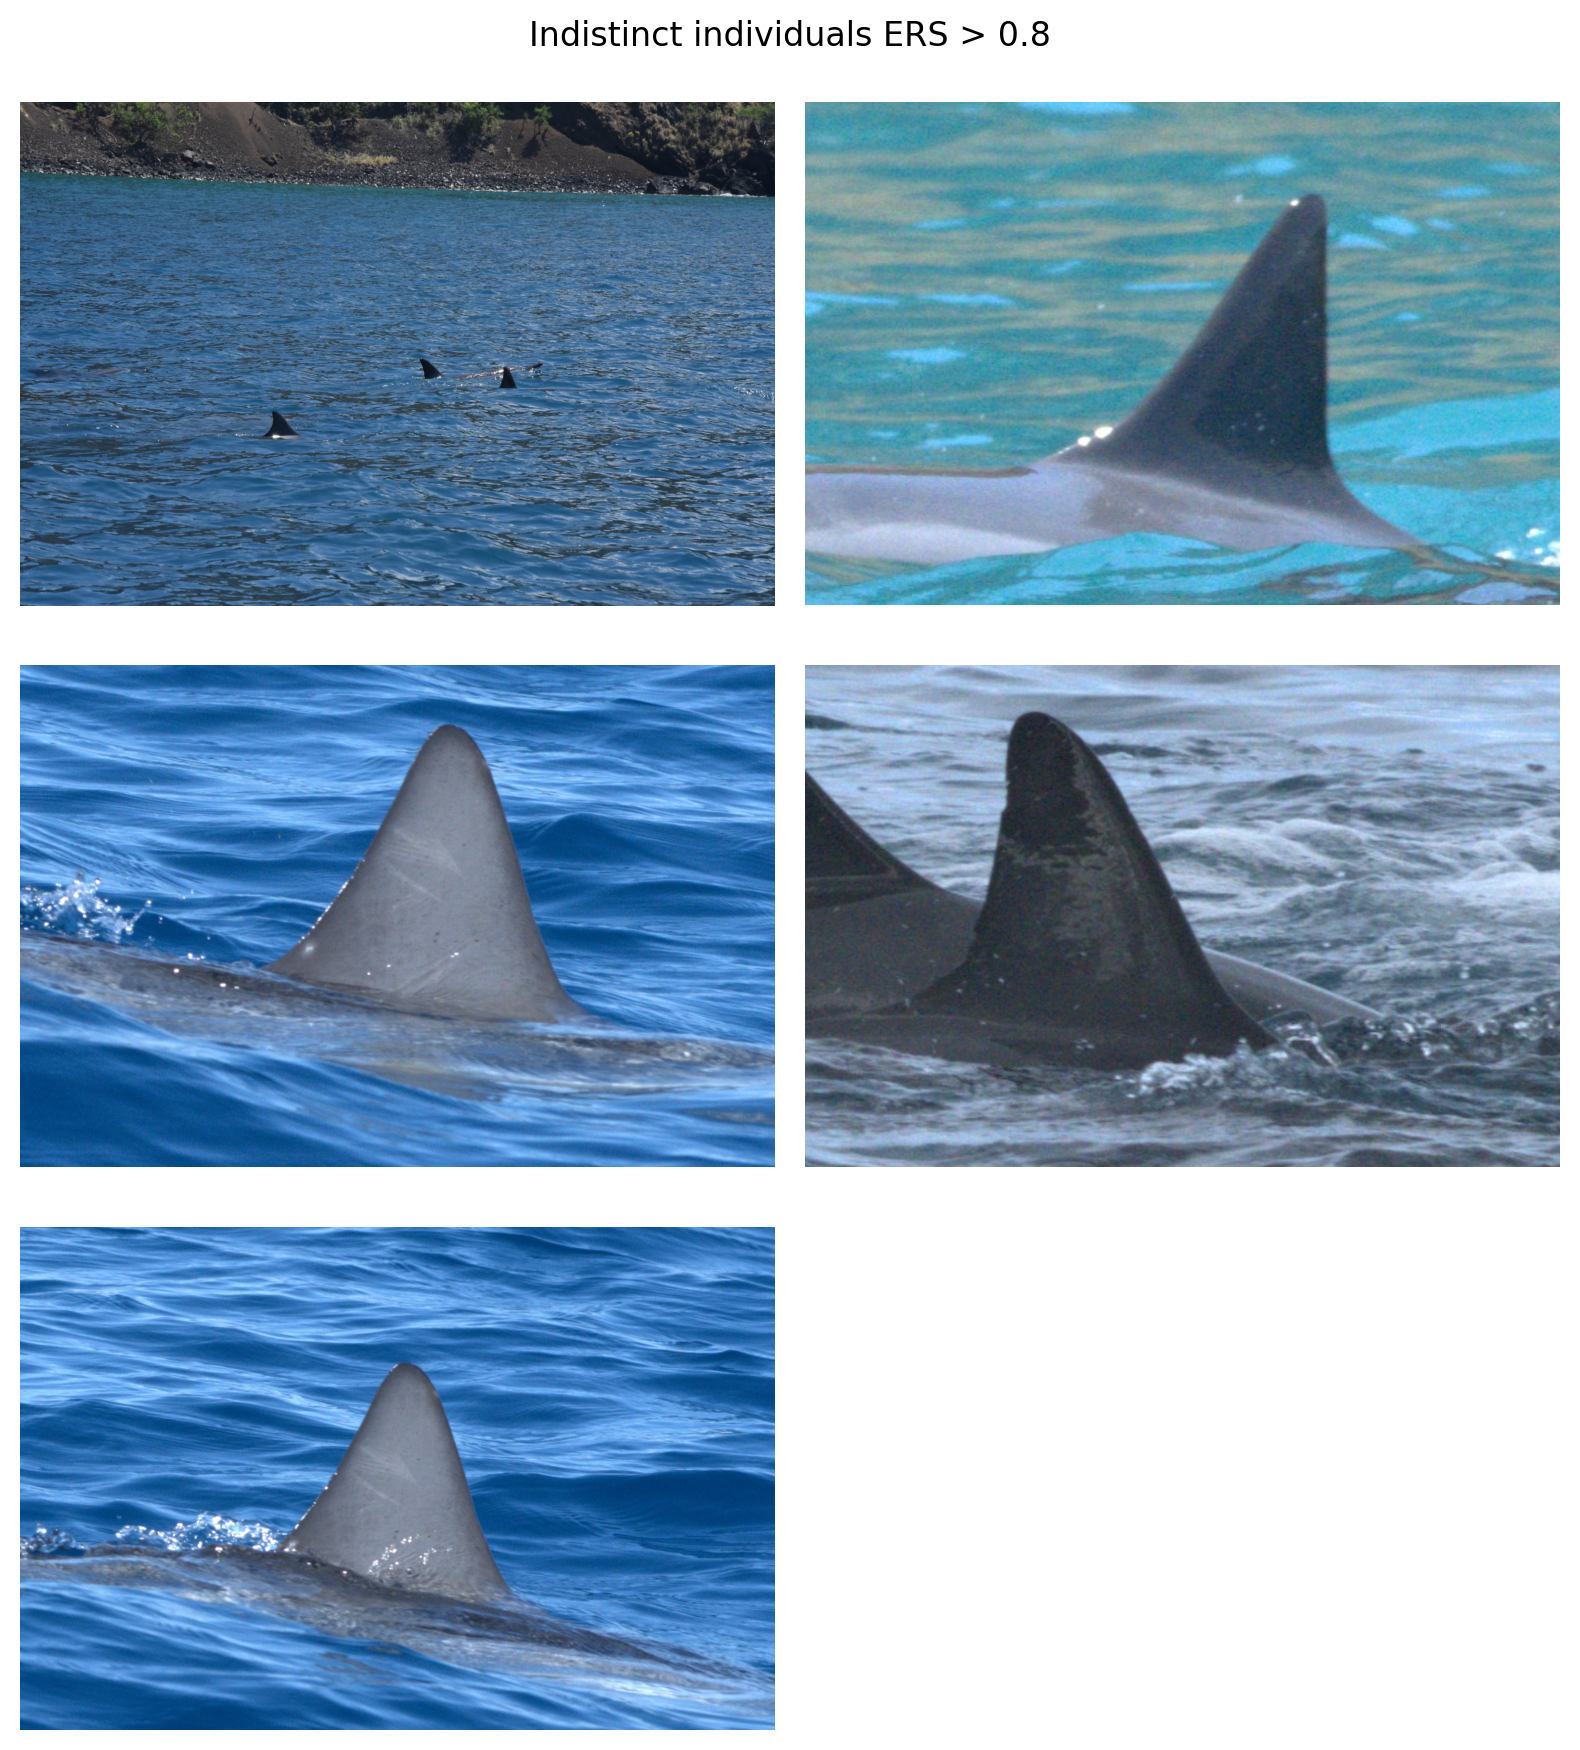

In [ ]:
outliers = ers_df.loc[(ers_df.distinctiveness == 'd3-d4') & (ers_df.ers > 0.8), 'image']
fig, axes = plt.subplots(3, 2, figsize=(8, 9))

for i, image in enumerate(outliers):
    ax = axes.flat[i]
    path = 'working_dir/all_images/' + image
    img = Image.open(path)
    ax.imshow(img)
    ax.axis('off')

axes[2, 1].remove()
fig.suptitle('Indistinct individuals ERS > 0.8')

plt.tight_layout()

(6,)


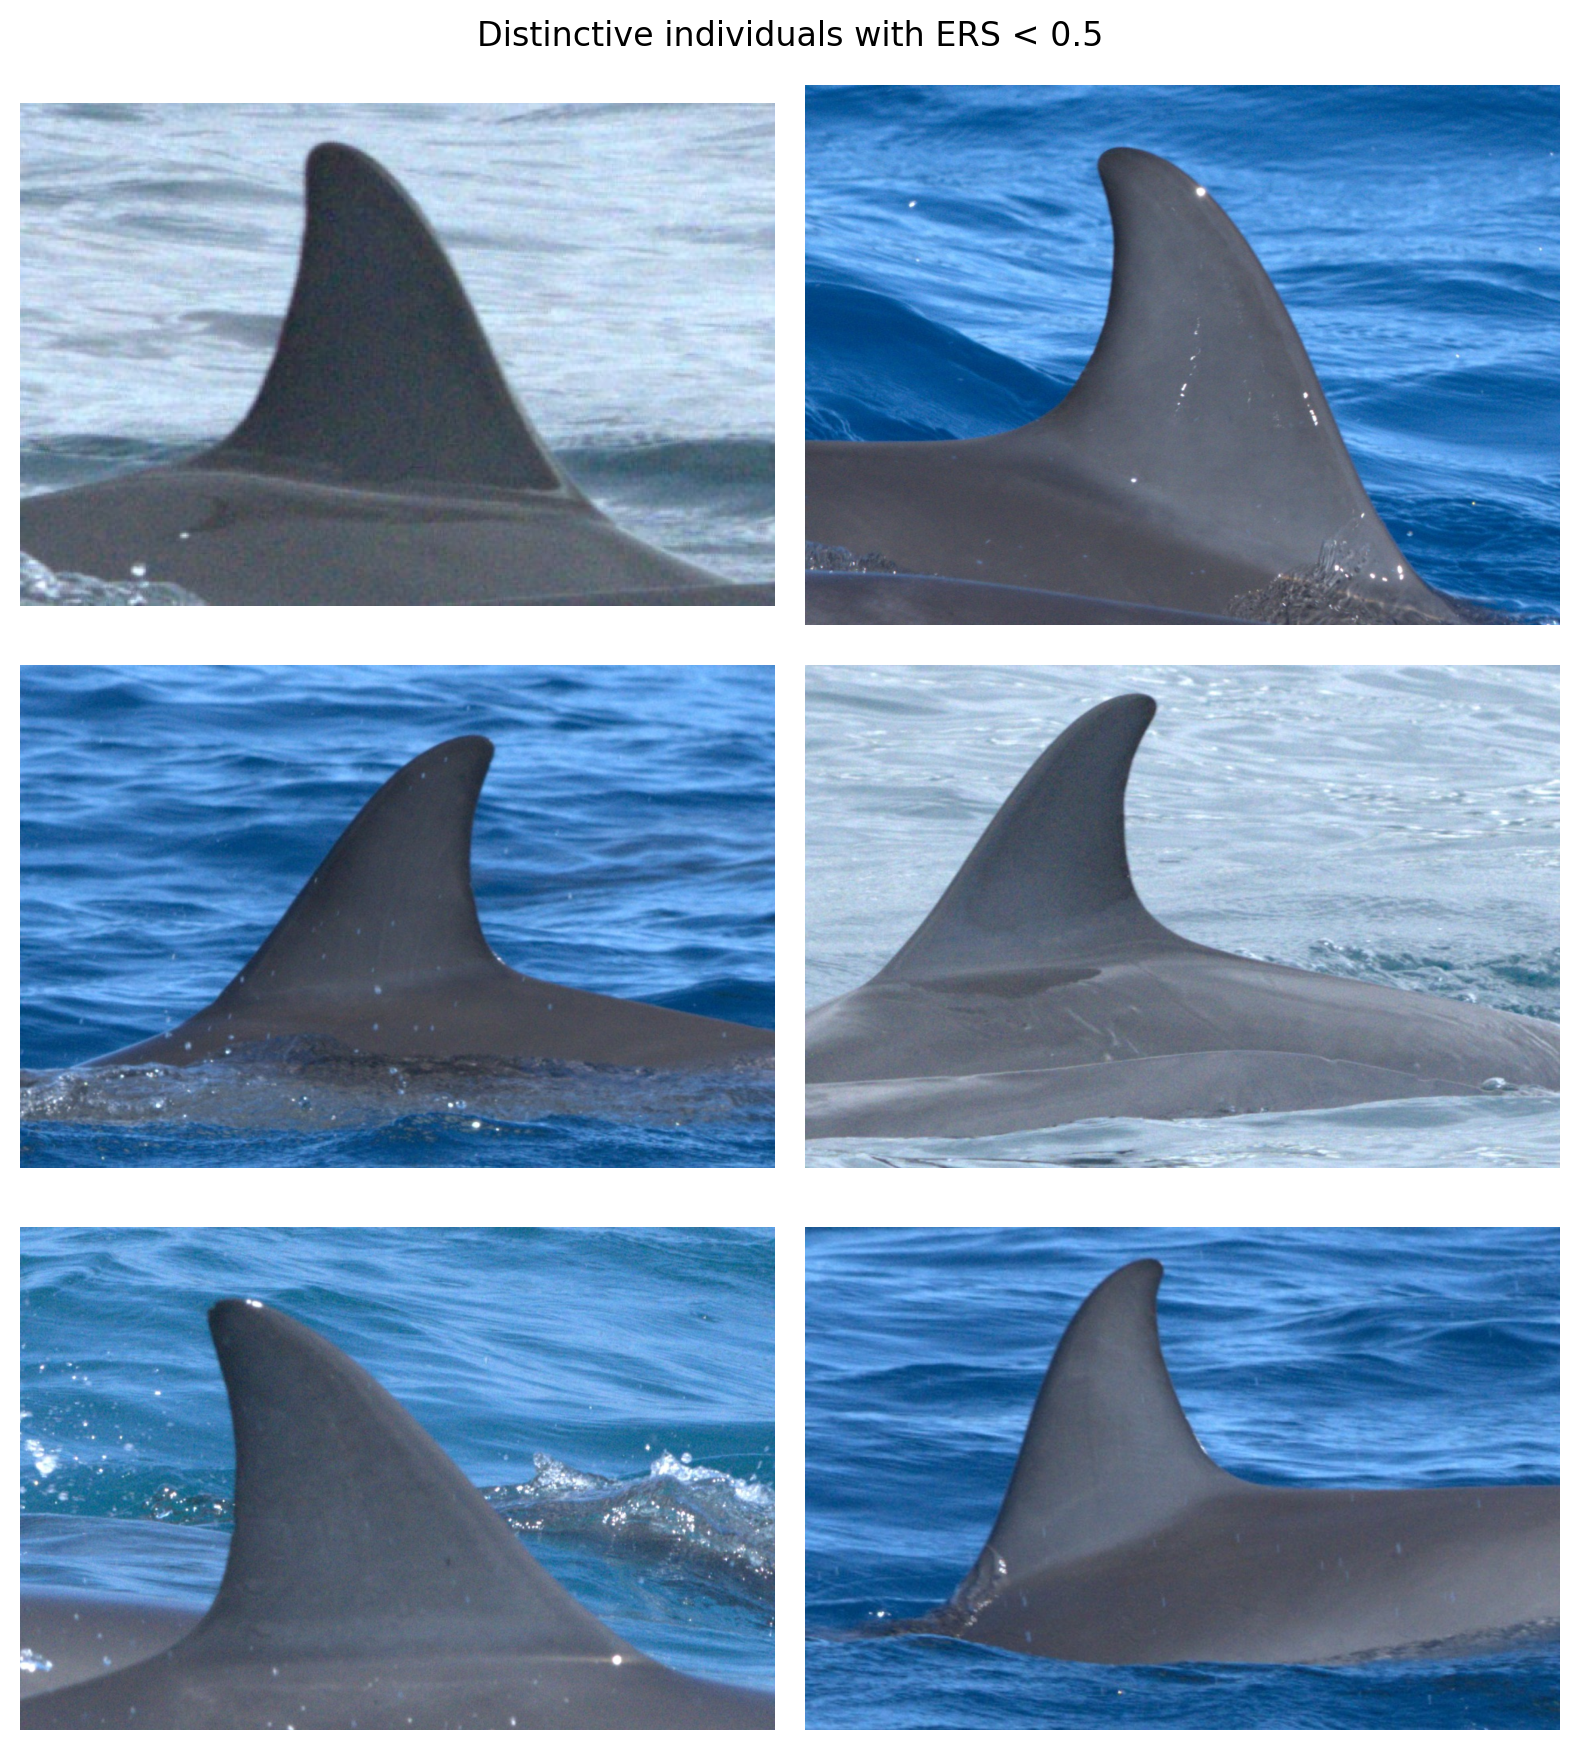

In [ ]:
outliers = ers_df.loc[(ers_df.distinctiveness == 'd1-d2') & (ers_df.ers < 0.5), 'image']
fig, axes = plt.subplots(3, 2, figsize=(8, 9))

for i, image in enumerate(outliers):
    ax = axes.flat[i]
    path = 'working_dir/all_images/' + image
    img = Image.open(path)
    ax.imshow(img)
    ax.axis('off')

fig.suptitle('Distinctive individuals with ERS < 0.5')

plt.tight_layout()

Text(0.5, 1.0, 'ROC Curve for \nDistinctiveness Classifier')

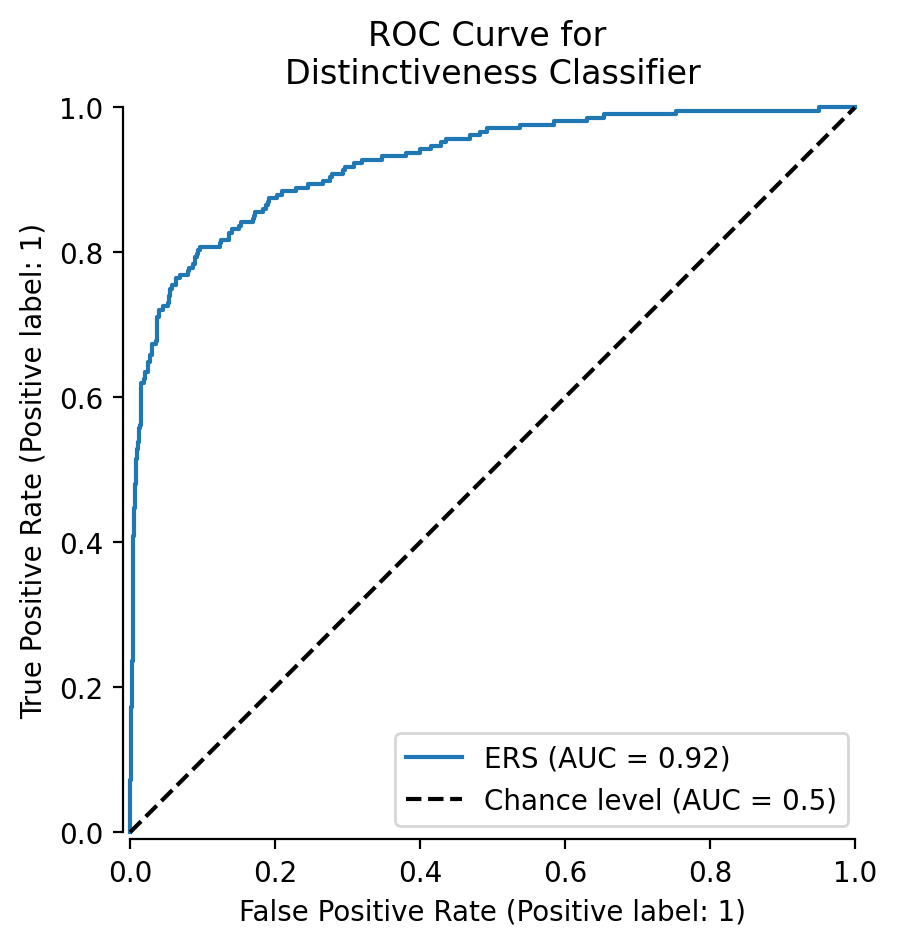

In [4]:

display = RocCurveDisplay.from_predictions(
    y_test, y_score, name="ERS", plot_chance_level=True, despine=True
)

ax = display.ax_.axes
ax.set_title('ROC Curve for \nDistinctiveness Classifier')

We can see that, for this example, the distinctiveness score is better than useless (gray dashed line).